In [40]:
import gc,uuid
import pandas as pd
import numpy as np
import pyarrow as pa
import tensorflow as tf
from pyarrow import parquet as pq
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [2]:
CATEGORICAL_DIM = ['item_id','dept_id','cat_id','store_id','state_id']
windowSize = 7
test_range = windowSize + 10

In [3]:
df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
df.index = df.id
df = df.drop('id',axis = 1)

In [5]:
testDate = list(map(lambda x: 'd_'+str(x),list(range(1913-test_range,1914))))
# trainDateDrop = list(map(lambda x: 'd_'+str(x),list(range(1,1001))))
trainDateDrop = []
test = df[CATEGORICAL_DIM+testDate]
train = df.drop(testDate+trainDateDrop,axis = 1)

In [6]:
# To-Do
# 1. Calendar event generator corresponding to certain date
# 2. Sell Price generator corresponding to certain date
# 3. Make tensorflow dataset
# 4. Make multi-step service

class feature_engineering(object):
    
    def __init__ (self,df,dimList,encoder = LabelEncoder,encodeDict = None):
        super().__init__()
        self._df = df
        self._dimList = dimList
        self.arr = df.drop(dimList,axis =1).values
        self.indexList = df.index.tolist()
        self._encoder = encoder
        self.labelDict,self.encodeDict = self._pandas_to_categorical_encode(encodeDict)


    def _rolling_window(self,a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    def _get_time_tensor(self,arr,window_size):
        tmp = self._rolling_window(arr,window_size+1)
        Xtensor = tmp[:,:-1].reshape(-1,window_size,1)
        Ytensor = tmp[:,-1].reshape(-1,1)
        return (Xtensor,Ytensor)

    def _tensor_factory(self,arr,window_size,categoryIx):
        X,Ytensor = self._get_time_tensor(arr,window_size)
        Xtensor = {}
        for i in self.labelDict:
            label = self.labelDict[i][categoryIx]
            Xtensor[i] = self._label_shape_transform(label,Ytensor.shape)
        Xtensor['sells'] = X
        return (Xtensor,Ytensor)

    def np_to_time_tensor_generator(self,windowSize):
        if np.ndim(self.arr) > 1:
            for ix,v in enumerate(self.arr):
                yield self._tensor_factory(v,windowSize,ix)
        else:
            yield self._tensor_factory(self.arr,windowSize,0) 

    def _label_encode(self,arr,encoder):
        if encoder is None:
            encoder = self._encoder()
            enc_arr = encoder.fit_transform(arr)
        else:
            enc_arr = encoder.transform(arr)
        return enc_arr,encoder

    def _pandas_to_categorical_encode(self,encodeDict):
        if encodeDict is None:
            encodeDict = {}
        labelDict = {}
        for i in self._dimList:
            if i in encodeDict:
                enc_arr,encoder = self._label_encode(self._df[i],encodeDict[i])
            else:
                enc_arr,encoder = self._label_encode(self._df[i],None)
            encodeDict[i] = encoder
            labelDict[i] = enc_arr
        return labelDict,encodeDict

    def _label_shape_transform(self,label,shape):
        tmp = np.zeros(shape)
        tmp += label
        return tmp

    def get_encoder_class(self,label):
        return len(self.encodeDict[label].classes_)
    
    def _get_tf_output_type(self):
        dct = {}
        for i in self.encodeDict:
            dct[i] = tf.int16
        dct['sells'] = tf.float32
        return (dct,tf.float32)
    
    def _get_tf_output_shape(self,window_size):
        dct = {}
        for i in self.encodeDict:
            dct[i] = tf.TensorShape([None,1])
        dct['sells'] = tf.TensorShape([None,window_size,1])
        return (dct,tf.TensorShape([None,1]))
    
    def get_tf_dataset(self,window_size):
        return tf.data.Dataset.from_generator(
                    self.np_to_time_tensor_generator,
                    self._get_tf_output_type(),
                    output_shapes = self._get_tf_output_shape(window_size),
                    args = [window_size]
        ), len(list(self.np_to_time_tensor_generator(window_size)))

# Model Training

In [7]:
fe = feature_engineering(train,['item_id','dept_id','cat_id','store_id','state_id'])
dept_id_class_num = fe.get_encoder_class('dept_id')
state_id_class_num = fe.get_encoder_class('state_id')
store_id_class_num = fe.get_encoder_class('store_id')
cat_id_class_num = fe.get_encoder_class('cat_id')

train_univariate,train_step = fe.get_tf_dataset(windowSize)
train_univariate = train_univariate.prefetch(tf.data.experimental.AUTOTUNE).repeat()

In [8]:
ge = feature_engineering(test,['item_id','dept_id','cat_id','store_id','state_id'],encodeDict= fe.encodeDict)

cacheFile = str(uuid.uuid4())
val_univariate,val_step = ge.get_tf_dataset(windowSize)
vals_univariate = val_univariate.prefetch(tf.data.experimental.AUTOTUNE).repeat()

In [13]:
sells_input = tf.keras.layers.Input(shape=(windowSize,1),name = 'sells')
cat_id_input= tf.keras.layers.Input(shape=1,name = 'cat_id')
store_id_input= tf.keras.layers.Input(shape=1,name = 'store_id')
dept_id_input = tf.keras.layers.Input(shape=1,name = 'dept_id')
state_id_input = tf.keras.layers.Input(shape=1,name = 'state_id')


dept_id = tf.keras.layers.Embedding(dept_id_class_num,2)(dept_id_input)
dept_id =tf.keras.layers.Flatten()(dept_id)

state_id = tf.keras.layers.Embedding(dept_id_class_num,2)(state_id_input)
state_id =tf.keras.layers.Flatten()(state_id)

cat_id = tf.keras.layers.Embedding(cat_id_class_num,2)(cat_id_input)
cat_id =tf.keras.layers.Flatten()(cat_id)

store_id = tf.keras.layers.Embedding(store_id_class_num,2)(store_id_input)
store_id =tf.keras.layers.Flatten()(store_id)

lstm = tf.keras.layers.LSTM(3)(sells_input)
lstm = tf.keras.layers.Dense(10,'relu')(lstm)

cate = tf.keras.layers.Concatenate()([cat_id,store_id,dept_id,state_id])
cate = tf.keras.layers.Dense(2,'elu')(cate)


dense = tf.keras.layers.Concatenate()([lstm,cate])
dense = tf.keras.layers.Dense(20,'relu')(dense)
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.Dense(5,'relu')(dense)
dense = tf.keras.layers.Dense(1,'relu')(dense)
simple_lstm_model = tf.keras.models.Model({
    'sells':sells_input,
    'cat_id':cat_id_input,
    'dept_id':dept_id_input,
    'state_id':state_id_input,
    'store_id':store_id_input
},dense)
simple_lstm_model.compile(optimizer='adam', loss='mse',metrics = ['mae','mse'])

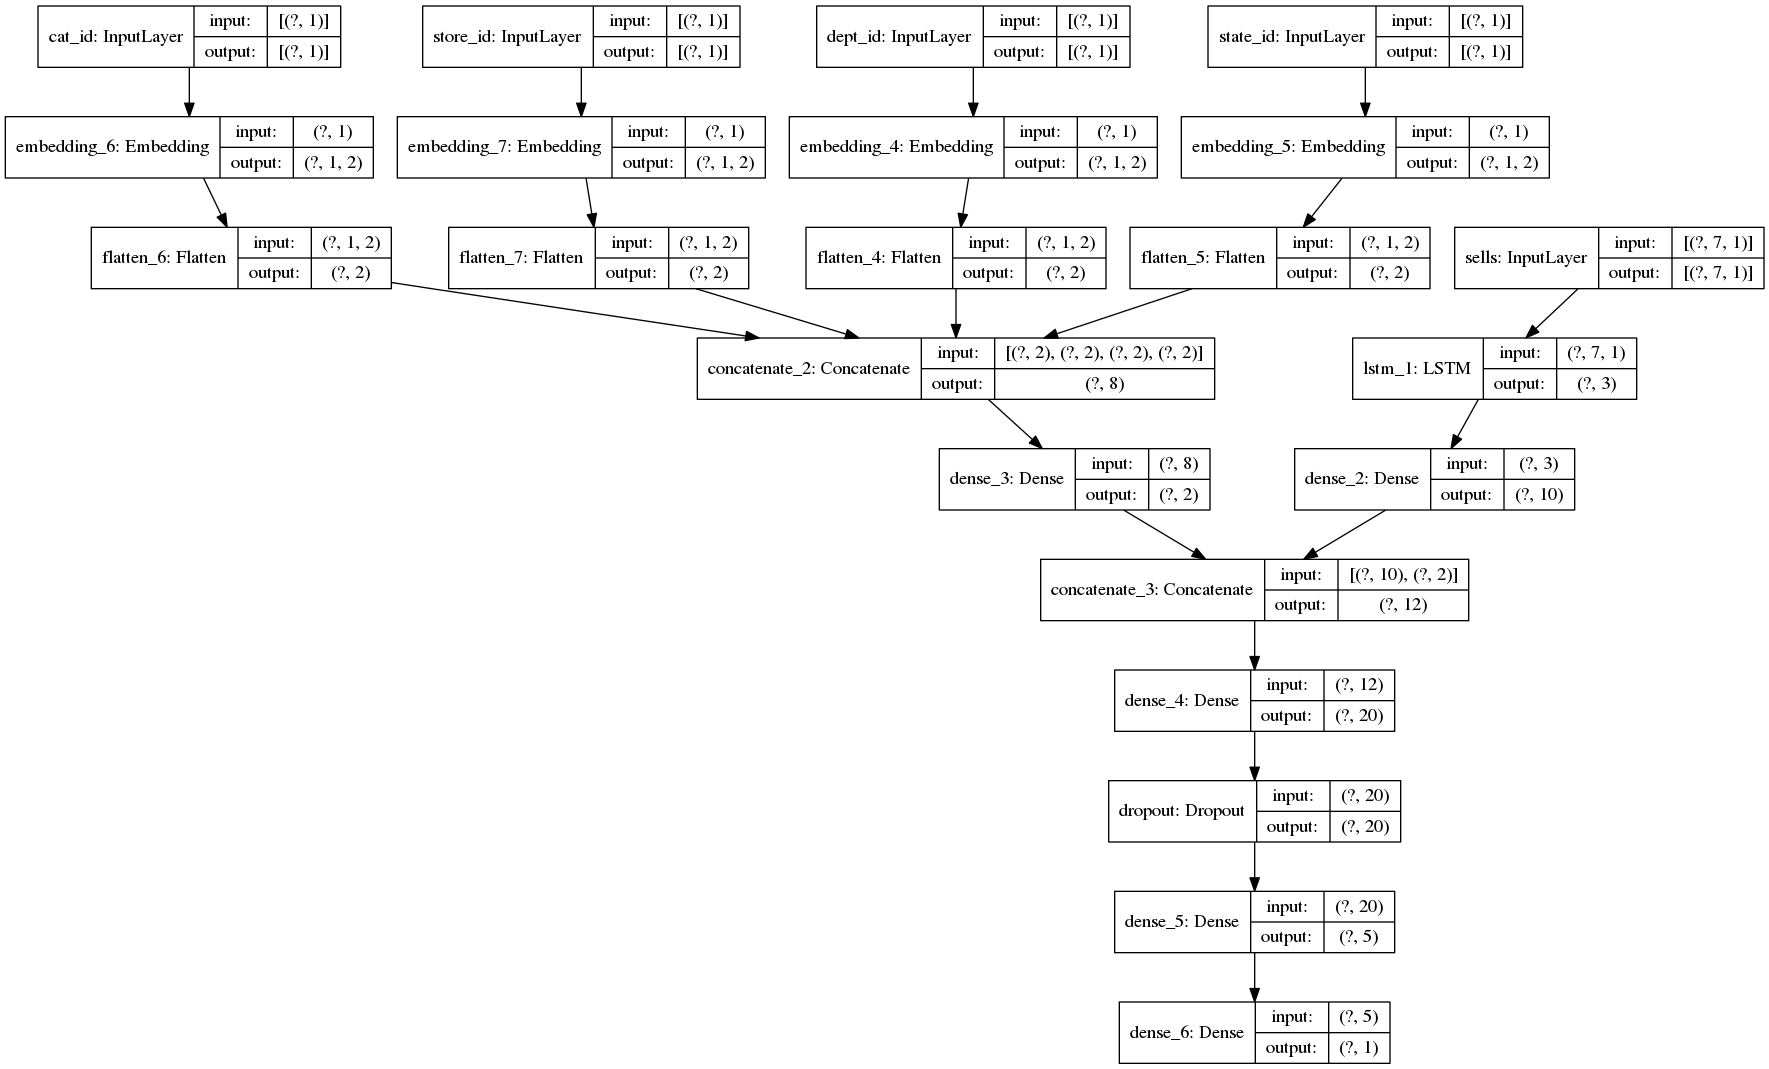

In [14]:
tf.keras.utils.plot_model(simple_lstm_model,show_shapes=True)

In [11]:
EVALUATION_INTERVAL = len(list(fe.np_to_time_tensor_generator(windowSize)))
validation_steps = len(list(ge.np_to_time_tensor_generator(windowSize)))
EPOCHS = 20

In [15]:
simple_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch= EVALUATION_INTERVAL,
    validation_data=vals_univariate, 
    validation_steps=validation_steps
    )

Train for 30490 steps, validate for 30490 steps
Epoch 1/5
30490/30490 [==============================] - 382s 13ms/step - loss: 6.0423 - mae: 0.8636 - mse: 6.0423 - val_loss: 4.8823 - val_mae: 1.2537 - val_mse: 4.8823
Epoch 2/5
30490/30490 [==============================] - 375s 12ms/step - loss: 5.5067 - mae: 0.8583 - mse: 5.5067 - val_loss: 4.2439 - val_mae: 1.0584 - val_mse: 4.2440
Epoch 3/5
30490/30490 [==============================] - 378s 12ms/step - loss: 5.4324 - mae: 0.8584 - mse: 5.4324 - val_loss: 4.2245 - val_mae: 1.0203 - val_mse: 4.2245
Epoch 4/5
30490/30490 [==============================] - 379s 12ms/step - loss: 5.4190 - mae: 0.8553 - mse: 5.4191 - val_loss: 4.1998 - val_mae: 0.9869 - val_mse: 4.1997
Epoch 5/5
30490/30490 [==============================] - 380s 12ms/step - loss: 5.2323 - mae: 0.8512 - mse: 5.2323 - val_loss: 4.2420 - val_mae: 0.9875 - val_mse: 4.2419


In [16]:
def batch_predict(estimator,gen,outputShape):
    for ix,v in enumerate(gen):
        if ix == 0:
            dct = v[0]
            continue
        for i in v[0]:
            dct[i] = np.concatenate((dct[i],v[0][i]))
    prd = estimator.predict(dct, verbose =1)
    return prd.reshape(outputShape)

In [17]:
prd = batch_predict(simple_lstm_model,ge.np_to_time_tensor_generator(windowSize),(-1,11))

335390/335390 [==============================] - 32s 96us/sample


In [29]:
prdDf = pd.DataFrame(prd,columns = testDate[-11:])
prdDf['cat_id']  = test.cat_id.values
prdDf = prdDf.groupby('cat_id').sum()

In [34]:
testDf = test.drop(['item_id','dept_id','store_id','state_id'],axis =1).groupby('cat_id').sum()

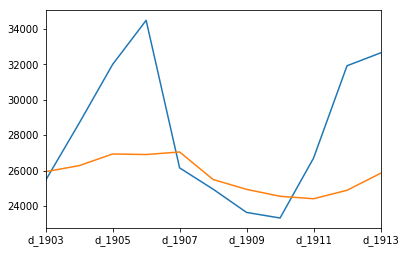

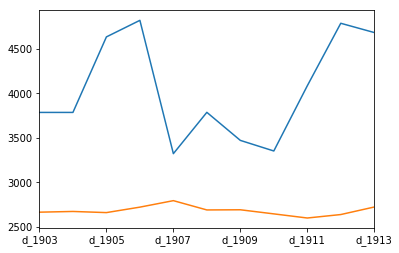

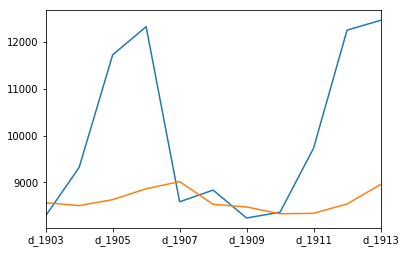

In [41]:
for i in range(len(testDf)):
    testDf.iloc[i,-11:].plot()
    prdDf.iloc[i].plot()
    plt.show()

# Submission

In [ ]:
prdDate = list(map(lambda x: 'd_'+str(x),list(range(1914-windowSize,1914))))
prdDf = df[CATEGORICAL_DIM+prdDate]

In [ ]:
for i in range(28):
    print(i)
    dtList = prdDf.columns.tolist()
    [dtList.remove(i) for i in CATEGORICAL_DIM]
    dtList = dtList[-windowSize:]
    prdDf = prdDf[CATEGORICAL_DIM+dtList]

    prdDf['d_'+ str(int(prdDf.columns.tolist()[-1].split('_')[-1])+1)] = -1
    pe = feature_engineering(prdDf,['item_id','dept_id','cat_id','store_id','state_id'],encodeDict= fe.encodeDict)
    gen = pe.np_to_time_tensor_generator(windowSize)
    prd = simple_lstm_model.predict_generator(gen,use_multiprocessing = True, verbose =1)
    prdDf[prdDf.columns[-1]] = list(map(lambda x: float(x[0]) ,prd))